Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [24]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [25]:
## If you are using the data by mounting the google drive, use the following :
# from google.colab import drive
# drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [26]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [27]:
batch_size = 32
img_height = 180
img_width = 180
AUTOTUNE = tf.data.experimental.AUTOTUNE

Use 80% of the images for training, and 20% for validation.

In [28]:
## Write your test dataset here
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

# Using image_dataset_from_directory since we do add or remove images in Test dir.
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [29]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset


# Chosing to use tf.data.Dataset.list_files over tf.keras.preprocessing.image_dataset_from_directory for Train dataset
# Justification: Train we adds more images in sub of each classes in Train diretory. If we use image_dataset_from_directory here when we are re-running this notebook from begining while we had already generated augmented images, even augmnted images will be included.
# I want section to only used original images. Hence taking this approach.
# get list of images from all the class directories
list_ds = tf.data.Dataset.list_files(str(data_dir_train/'*/*.jpg'), shuffle=False)
list_ds = list_ds.shuffle(image_count_train, reshuffle_each_iteration=False, seed=123)

print(len(list_ds))

val_size = int(image_count_train * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())


2239
1792
447


In [30]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.

class_names = [subdir.name for subdir in data_dir_train.iterdir() if subdir.is_dir()]
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [31]:
# data set prepparation related functions

def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

def configure_for_performance(ds, shouldShuffle=False):
  ds = ds.cache()
  if shouldShuffle :
    ds = ds.shuffle(buffer_size=1000)

  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

def visualize_training_result(history, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [32]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

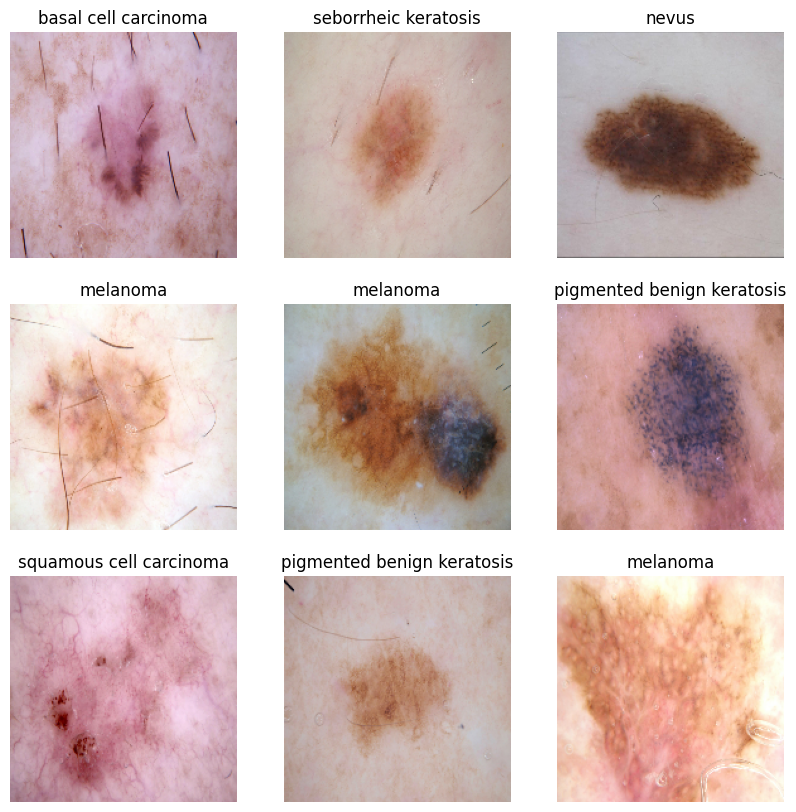

In [33]:
plt.figure(figsize=(10, 10))

index = 0
for image_batch, label_batch in train_ds.take(9):
  ax = plt.subplot(3, 3, index + 1)
  plt.imshow(image_batch.numpy().astype("uint8"))
  label = label_batch
  plt.title(class_names[label])
  plt.axis("off")
  index += 1

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [34]:
train_ds = configure_for_performance(train_ds, shouldShuffle=True)
val_ds = configure_for_performance(val_ds)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [35]:
num_classes = len(class_names)

model = Sequential([
  keras.Input(batch_shape=(batch_size, img_height, img_width, 3)),
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [36]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [37]:
# View the summary of all layers
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (32, 180, 180, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 180, 180, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 90, 90, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 90, 90, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 45, 45, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 45, 45, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 22, 22, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (32, 30976)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 128)              │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 9)                │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [21]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 227ms/step - accuracy: 0.2199 - loss: 2.4101 - val_accuracy: 0.3624 - val_loss: 1.8528
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - accuracy: 0.3261 - loss: 1.7979 - val_accuracy: 0.3624 - val_loss: 1.6748
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 163ms/step - accuracy: 0.4193 - loss: 1.5972 - val_accuracy: 0.5168 - val_loss: 1.4371
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 0.4916 - loss: 1.4498 - val_accuracy: 0.4609 - val_loss: 1.5420
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 0.5218 - loss: 1.3355 - val_accuracy: 0.5056 - val_loss: 1.3814
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 0.5532 - loss: 1.2738 - val_accuracy: 0.5414 - val_loss: 1.3424
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 152ms/step - accuracy: 0.5583 - loss: 1.1857 - val_accuracy: 0.5615 - val_loss: 1.3468
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - accuracy: 0.6037 - loss: 1.1278 - val_accuracy: 0

### Visualizing training results

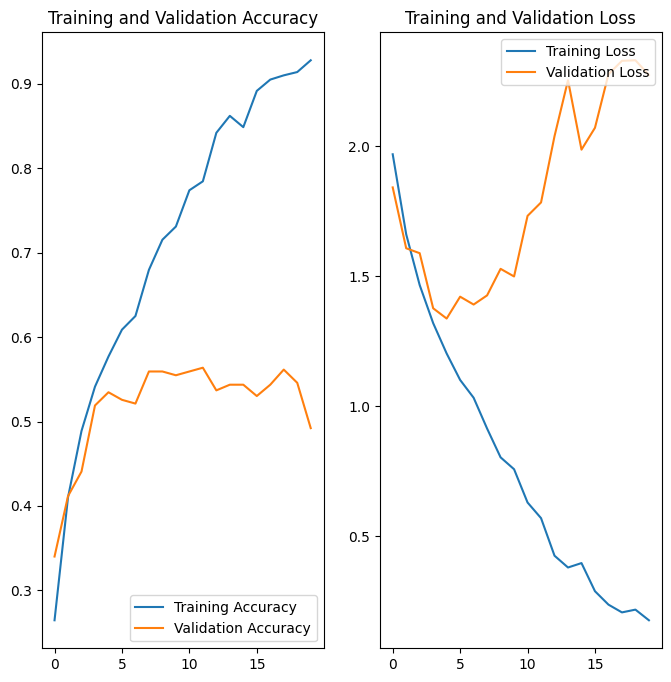

In [22]:
visualize_training_result(history, epochs)

In [23]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_test, accuracy_test = model.evaluate(test_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_test)
print("Loss: ",loss)
print("Validation Loss", loss_test)

56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9352 - loss: 0.1520
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 518ms/step - accuracy: 0.3093 - loss: 5.2526
Accuracy:  0.9408482313156128
Validation Accuracy:  0.3305084705352783
Loss:  0.14524225890636444
Validation Loss 5.31873893737793


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

In [21]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here
# There is no edidence of oferfitting or underfitting.
# We could try adding augmentation to see if that helps in improving the acuracy

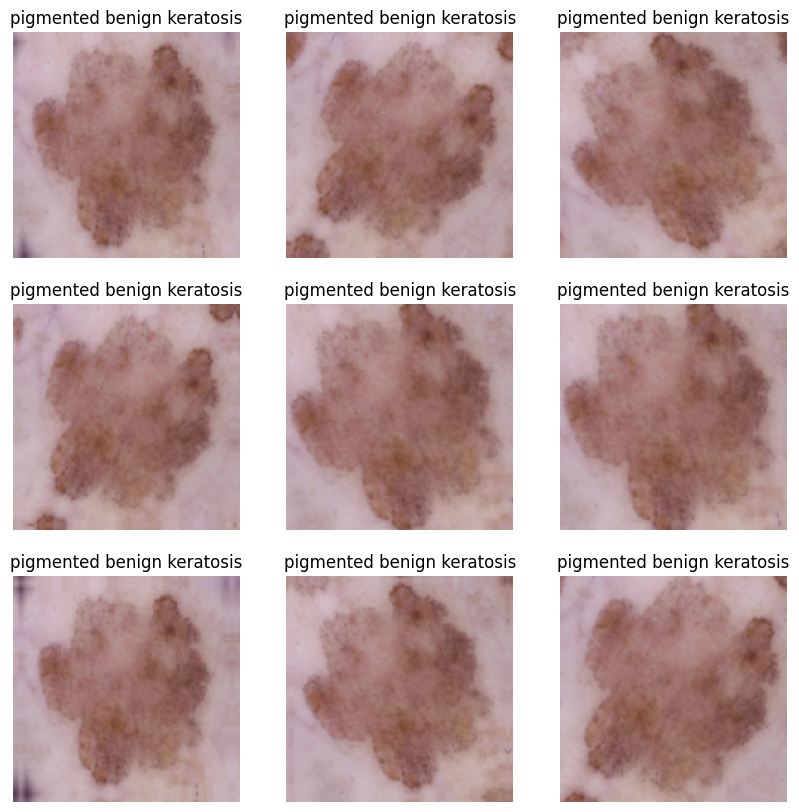

In [99]:
data_augmentation = keras.Sequential(
  [
    #layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    aug_image = data_augmentation(images)
    plt.imshow(aug_image[0].numpy().astype("uint8"))
    plt.title(class_names[labels[0]])
    plt.axis("off")


### Todo:
### Create the model, compile and train the model


In [100]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model = Sequential([
  keras.Input(batch_shape=(batch_size, img_height, img_width, 3)),
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compiling the model

In [101]:
## Your code goes here

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [102]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_5 (Sequential)       │ (32, 180, 180, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (32, 180, 180, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (32, 180, 180, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (32, 90, 90, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (32, 90, 90, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (32, 45, 45, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (32, 45, 45, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (32, 22, 22, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (32, 30976)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (32, 128)              │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (32, 9)                │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [103]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - accuracy: 0.1987 - loss: 2.4468 - val_accuracy: 0.2506 - val_loss: 2.0042
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 154ms/step - accuracy: 0.3077 - loss: 1.8694 - val_accuracy: 0.4072 - val_loss: 1.6378
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 155ms/step - accuracy: 0.4534 - loss: 1.5601 - val_accuracy: 0.4877 - val_loss: 1.4369
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 171ms/step - accuracy: 0.4708 - loss: 1.4565 - val_accuracy: 0.5324 - val_loss: 1.3860
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 157ms/step - accuracy: 0.5284 - loss: 1.3053 - val_accuracy: 0.5302 - val_loss: 1.3414
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 174ms/step - accuracy: 0.5341 - loss: 1.2882 - val_accuracy: 0.4855 - val_loss: 1.4050
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - accuracy: 0.5563 - loss: 1.2202 - val_accuracy: 0.5168 - val_loss: 1.3575
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 157ms/step - accuracy: 0.5496 - loss: 1.2219 - val_accuracy: 

### Visualizing the results

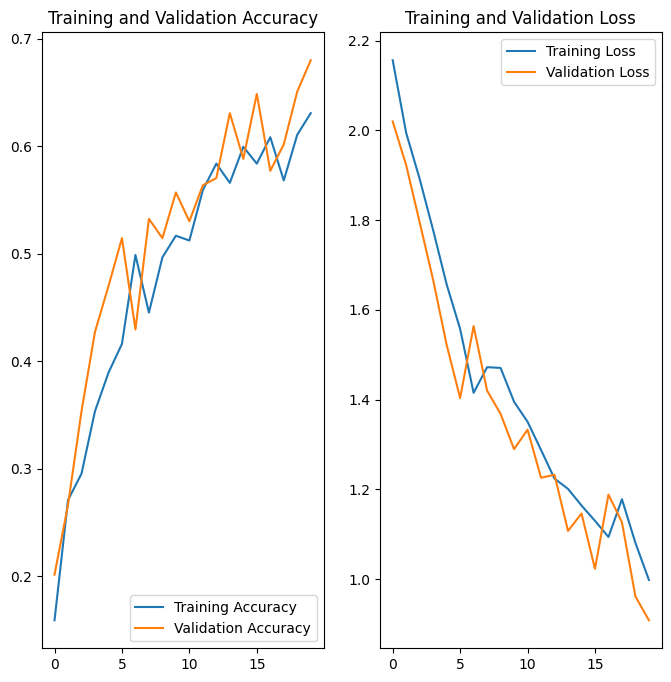

In [27]:
visualize_training_result(history, epochs)

In [ ]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_test, accuracy_test = model.evaluate(test_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_test)
print("Loss: ",loss)
print("Validation Loss", loss_test)

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [28]:
## Your code goes here.

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

2239


In [ ]:
path_list = [x for x in data_dir_train.glob(os.path.join('*','*.jpg'))]
print(len(path_list))

In [ ]:
lesion_list = [os.path.basename(os.path.dirname(y)) for y in path_list]
print(len(lesion_list))

In [31]:
dataframe_dict = dict(zip(path_list, lesion_list))

In [32]:
original_files = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])
original_files.head()

,Path,Label
0,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
1,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
2,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
3,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
4,Skin cancer ISIC The International Skin Imagin...,actinic keratosis


In [33]:
original_files['Label'].value_counts()

Label
pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: count, dtype: int64

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?

We see imbalance of data among different classes.
"seborrheic keratosis" class has least amount of data (77)
Data is dominoated from classes: "pigmented benign keratosis", "melanoma", "basal cell carcinoma" and "nevus"

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [34]:
# install Augmentor is not installed already

!pip install Augmentor

Defaulting to user installation because normal site-packages is not writeable


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
# check if output directory exists and has images already
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

In [35]:

if image_count_train == 0:
    # Augmentation not been done in any of previous iteration
    import Augmentor
    for i in class_names:
        p = Augmentor.Pipeline(data_dir_train / i)
        p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
        p.zoom(probability=0.7, min_factor=1.1, max_factor=1.3)
        p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Defaulting to user installation because normal site-packages is not writeable
Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x18965D94170>: 100%|██████████| 500/500 [00:04<00:00, 119.73 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x189320428A0>: 100%|██████████| 500/500 [00:04<00:00, 109.22 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1897FBA8BF0>: 100%|██████████| 500/500 [00:05<00:00, 97.43 Samples/s]                   


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\melanoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x1896F40F3E0>: 100%|██████████| 500/500 [00:24<00:00, 20.67 Samples/s] 


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\nevus\output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x1897CFF22D0>: 100%|██████████| 500/500 [00:20<00:00, 24.57 Samples/s]                    


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1897CFAE030>: 100%|██████████| 500/500 [00:04<00:00, 123.90 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x189660AA870>: 100%|██████████| 500/500 [00:09<00:00, 52.84 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1896F5361E0>: 100%|██████████| 500/500 [00:03<00:00, 128.65 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1897FBAB530>: 100%|██████████| 500/500 [00:04<00:00, 122.14 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [36]:
# check for output directory again
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
path_list = [x for x in data_dir_train.glob(os.path.join('*','output', '*.jpg'))]
print(len(path_list))

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in path_list]
print(len(lesion_list_new))

In [39]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [40]:
generated_files = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
print(generated_files.head())
all_files_including_generated = pd.concat([original_files, generated_files])
print(all_files_including_generated.head())

                                                Path              Label
0  Skin cancer ISIC The International Skin Imagin...  actinic keratosis
1  Skin cancer ISIC The International Skin Imagin...  actinic keratosis
2  Skin cancer ISIC The International Skin Imagin...  actinic keratosis
3  Skin cancer ISIC The International Skin Imagin...  actinic keratosis
4  Skin cancer ISIC The International Skin Imagin...  actinic keratosis
                                                Path              Label
0  Skin cancer ISIC The International Skin Imagin...  actinic keratosis
1  Skin cancer ISIC The International Skin Imagin...  actinic keratosis
2  Skin cancer ISIC The International Skin Imagin...  actinic keratosis
3  Skin cancer ISIC The International Skin Imagin...  actinic keratosis
4  Skin cancer ISIC The International Skin Imagin...  actinic keratosis


In [41]:
all_files_including_generated['Label'].value_counts()

Label
pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

#### **Todo:** Create a training dataset

In [43]:
# we should create file list based data set for original imagea and augmented images and concatnate them


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [44]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [45]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### **Todo:** Create your model (make sure to include normalization)

In [46]:
## your code goes here

model = Sequential([
  keras.Input(batch_shape=(batch_size, img_height, img_width, 3)),
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

C:\Users\rajranja\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [47]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [48]:
## your code goes here
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [49]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 40s 147ms/step - accuracy: 0.2641 - loss: 1.9255 - val_accuracy: 0.4633 - val_loss: 1.4799
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 21s 127ms/step - accuracy: 0.5169 - loss: 1.3212 - val_accuracy: 0.5843 - val_loss: 1.1498
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 21s 125ms/step - accuracy: 0.5917 - loss: 1.1087 - val_accuracy: 0.5746 - val_loss: 1.1657
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 22s 130ms/step - accuracy: 0.6743 - loss: 0.9136 - val_accuracy: 0.6652 - val_loss: 0.9210
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 22s 128ms/step - accuracy: 0.7403 - loss: 0.7349 - val_accuracy: 0.6971 - val_loss: 0.8728
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 21s 125ms/step - accuracy: 0.8171 - loss: 0.5223 - val_accuracy: 0.7446 - val_loss: 0.7585
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 22s 128ms/step - accuracy: 0.8557 - loss: 0.4114 - val_accuracy: 0.7275 - val_loss: 0.8311
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 23s 137ms/step - accuracy: 0.8875 - loss: 0

#### **Todo:**  Visualize the model results

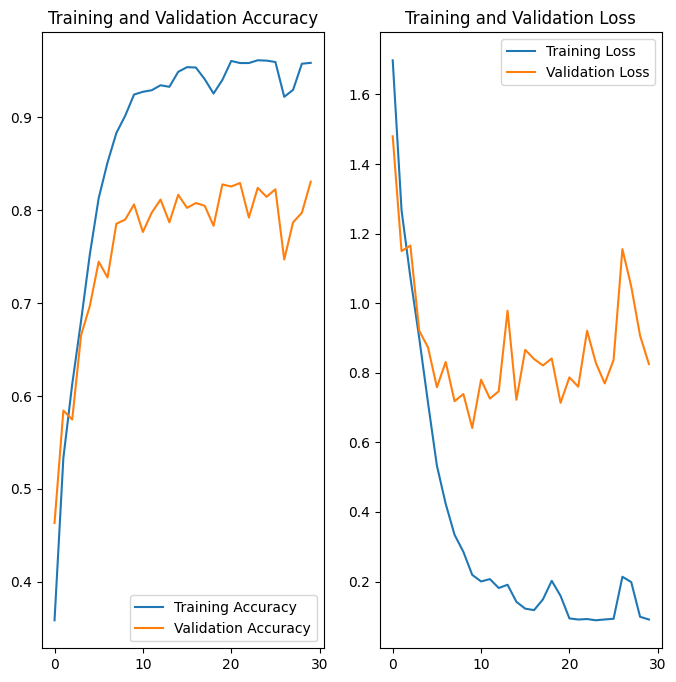

In [50]:
visualize_training_result(history, epochs)

In [ ]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_test, accuracy_test = model.evaluate(test_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_test)
print("Loss: ",loss)
print("Validation Loss", loss_test)

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



After 70% accuracy we see overfit after epoch around 8.
We should try dropout

In [66]:
## your code goes here

model = Sequential([
  keras.Input(batch_shape=(batch_size, img_height, img_width, 3)),
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [67]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_6 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [68]:
## your code goes here
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [69]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 20s 111ms/step - accuracy: 0.2026 - loss: 2.2322 - val_accuracy: 0.3912 - val_loss: 1.5425
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 21s 124ms/step - accuracy: 0.4714 - loss: 1.4409 - val_accuracy: 0.5316 - val_loss: 1.3066
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 20s 121ms/step - accuracy: 0.5378 - loss: 1.2478 - val_accuracy: 0.5501 - val_loss: 1.2143
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 21s 126ms/step - accuracy: 0.6045 - loss: 1.0868 - val_accuracy: 0.6244 - val_loss: 0.9890
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 22s 131ms/step - accuracy: 0.6789 - loss: 0.8835 - val_accuracy: 0.6607 - val_loss: 0.9384
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 28s 169ms/step - accuracy: 0.7147 - loss: 0.7859 - val_accuracy: 0.6785 - val_loss: 0.8900
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 26s 153ms/step - accuracy: 0.7660 - loss: 0.6481 - val_accuracy: 0.6904 - val_loss: 0.8980
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 28s 169ms/step - accuracy: 0.8134 - loss: 0

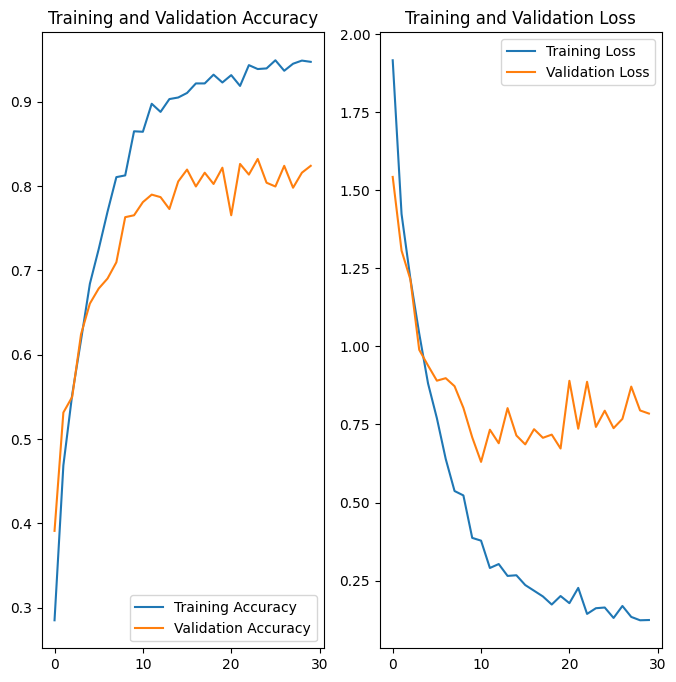

In [70]:
visualize_training_result(history, epochs)

In [ ]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_test, accuracy_test = model.evaluate(test_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_test)
print("Loss: ",loss)
print("Validation Loss", loss_test)